In [1]:
! pip install efficientnet
import os, glob, random
import numpy as np
import pandas as pd
import os
import math
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, activations, optimizers, losses, layers, callbacks, metrics, datasets, utils, regularizers, constraints


import wandb
from wandb.keras import WandbCallback

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20, 10)
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
student_id = 2000728661
os.environ['PYTHONHASHSEED'] = str(student_id)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(student_id)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(student_id)
random.seed(student_id)
np.random.seed(student_id)
tf.random.set_seed(student_id)
SEED=student_id
seed = student_id
np.random.seed(student_id)
import gc
gc.enable()
from collections import defaultdict
from functools import partial
import tensorflow_addons as tfa
import tensorflow.keras.applications as tfka
import efficientnet.tfkeras as efn
import re
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from kaggle_datasets import KaggleDatasets
import pickle

     |████████████████████████████████| 50 kB 1.4 MB/s 


2021-12-10 23:30:29.784861: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-10 23:30:29.784971: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-10 23:30:35.539389: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-10 23:30:35.541989: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-10 23:30:35.542013: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-10 23:30:35.542044: I tensorflow/stream_executor/cuda/cud

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-12-10 23:30:36.722518: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-10 23:30:36.722588: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-12-10 23:30:36.746203: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-10 23:30:36.746254: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-12-10 23:30:36.747228: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


REPLICAS:  8


In [3]:
AUTO = tf.data.experimental.AUTOTUNE
target_size = 256
IMAGE_SIZE = [256, 256]
input_shape = (*IMAGE_SIZE, 3)
representation_dim = 256
num_clusters = 30
k_neighbours = 5
tune_encoder_during_clustering = False
VOCAB_SIZE = 1871
LR = 0.0005
model_path = '../input/deepfoodie/Model_RN50_505.h5'
EPOCHS = 35
BATCH_SIZE = 32
img_path = '../input/deepfoodie/dataset_1_images/dataset_1_images/Food Images/'
GCS_PATH = KaggleDatasets().get_gcs_path('deepfoodiedataloaders')

train_set = tf.io.gfile.glob(GCS_PATH + '/train' + '*.tfrec')
val_set = tf.io.gfile.glob(GCS_PATH + '/val' + '*.tfrec')

TARGET = "cleaned_ingredients"
GCS_PATH

'gs://kds-2da7035f5087e01de519363d555030ef803278af8cdd2653927eb2fb'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Data augmentation function
def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image


# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "cleaned_ingredients": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "orig_ingredients": tf.io.FixedLenFeature([], tf.string),
#         "title": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
#         "instructions": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
#     title = example['title']
    # not being used in model, just there to be able to work tfrecs
#     ings = example['cleaned_ingredients']
    
    return  image

def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, ordered = False):
    dataset = load_dataset(filenames, ordered = ordered)
    dataset = dataset.map(partial(data_augment), num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our validation tensors
def get_validation_dataset(filenames, ordered = True):
    dataset = load_dataset(filenames, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Function to count how many photos we have in
def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_set)
print(f'Dataset: {NUM_TRAINING_IMAGES} training images')

Dataset: 10092 training images


In [5]:
train_dataset = get_training_dataset(train_set, ordered = False)

In [6]:
val_dataset = get_validation_dataset(val_set, ordered = True)

In [7]:
def get_encoder(weights_file=model_path, mode="RN50"):
    inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp')

    
    if mode == 'eff0':
        x = efn.EfficientNetB0(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'eff1':
        x = efn.EfficientNetB1(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'eff2':
        x = efn.EfficientNetB2(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'eff3':
        x = efn.EfficientNetB3(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'eff4':
        x = efn.EfficientNetB4(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'eff5':
        x = efn.EfficientNetB5(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'eff6':
        x = efn.EfficientNetB6(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'eff7':
        x = efn.EfficientNetB7(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'ICPV2':
        x = tfka.InceptionResNetV2(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'ICPV3':
        x = tfka.InceptionV3(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'XCP':
        x = tfka.Xception(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'VGG16':
        x = tfka.VGG16(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'VGG19':
        x = tfka.VGG19(weights = 'imagenet', include_top = False)(inp)
    elif mode == 'RN50':
        x = tfka.ResNet50(weights = 'imagenet', include_top = False)(inp)
    else:
        # 'RN101'
        x = tfka.ResNet101(weights = 'imagenet', include_top = False)(inp)
    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pooling')(x)

    x = tf.keras.layers.Dense(256, name='ing_embedding')(x)

    output = tf.keras.layers.Dense(VOCAB_SIZE, activation='sigmoid', name='output')(x)

    model = tf.keras.models.Model(inputs = [inp], outputs = [output])
    opt = tf.keras.optimizers.Adam(learning_rate = LR)

    model.compile(
        optimizer = opt,
        loss="binary_crossentropy"

        ) 

    model.load_weights(weights_file)
    encoder = keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    print("original model")
    print(encoder.summary())
    return model, encoder



In [8]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units=256,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=True,
        batch_size=BATCH_SIZE,
        tpu=tpu,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.bs = batch_size
        self.tpu=tpu

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors):

        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.eye(4) if self.tpu else tf.tile(tf.eye(self.bs), [2, 2])

        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Apply projection head.
        return self.projector(inputs)
        

    def train_step(self, inputs):
        # Run the forward pass and compute the contrastive loss
        # removing encoder from tape
        features = self.encoder(inputs)
        with tf.GradientTape() as tape:
            # might have to do some other training value
            feature_vectors = self(features, training=True)
            loss = self.compute_contrastive_loss(feature_vectors)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        features = self.encoder(inputs)
        feature_vectors = self(features, training=False)
        loss = self.compute_contrastive_loss(feature_vectors)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [9]:
STEPS_PER_EPOCH = count_data_items(train_set) // BATCH_SIZE
K.clear_session()

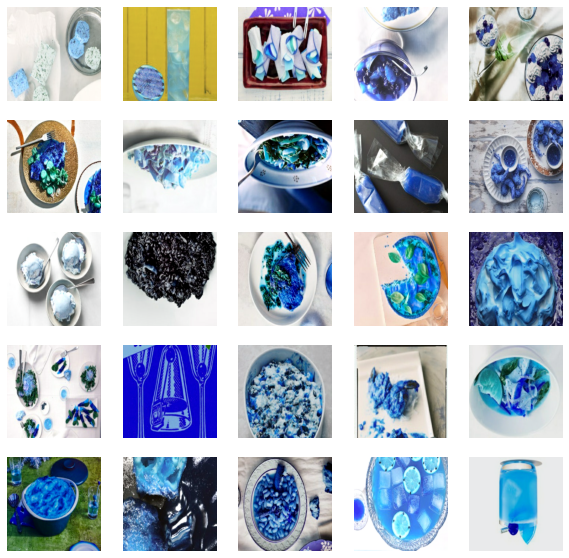

In [10]:
image_batch = next(iter(train_dataset))
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.axis("off")

show_batch(image_batch.numpy())

In [11]:
with strategy.scope():

    # Create vision encoder.
    _, encoder = get_encoder()
    # Create representation learner.
    representation_learner = RepresentationLearner(
        encoder, temperature=0.1
    )
    # Create a a Cosine decay learning rate scheduler.
    lr_scheduler = keras.experimental.CosineDecay(
        initial_learning_rate=0.0001, decay_steps=EPOCHS, alpha=0.1
    )
    
    # Compile the model.
    representation_learner.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
    )
    
# Fit the model.
filepath = "saved-model-{epoch:02d}-{val_loss:.4f}.hdf5"

c=[
#                         WandbCallback(monitor='val_loss', mode="max"),
#                         callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=50, min_lr=1e-10),
                        callbacks.ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1, mode='min')
                    ],
history = representation_learner.fit(
    x=train_dataset,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=EPOCHS,  # for better results, increase the number of epochs to 500.
    validation_data=val_dataset,
    callbacks=c
)

94773248/94765736 [==============================] - 1s 0us/step
original model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
avg_pooling (GlobalAveragePo (None, 2048)              0         
_________________________________________________________________
ing_embedding (Dense)        (None, 256)               524544    
Total params: 24,112,256
Trainable params: 24,059,136
Non-trainable params: 53,120
_________________________________________________________________
None
Epoch 1/35
315/315 [==============================] - 29s 57ms/step - loss: 7.9522e-04 - val_loss: 0.0696


2021-12-10 23:31:37.556080: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 31252, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1639179097.552473947","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 31252, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.06961, saving model to saved-model-01-0.0696.hdf5
Epoch 2/35
315/315 [==============================] - 10s 31ms/step - loss: 7.8795e-04 - val_loss: 0.0631

Epoch 00002: val_loss improved from 0.06961 to 0.06307, saving model to saved-model-02-0.0631.hdf5
Epoch 3/35
315/315 [==============================] - 10s 31ms/step - loss: 7.7994e-04 - val_loss: 0.0629

Epoch 00003: val_loss improved from 0.06307 to 0.06292, saving model to saved-model-03-0.0629.hdf5
Epoch 4/35
315/315 [==============================] - 10s 31ms/step - loss: 7.7401e-04 - val_loss: 0.0619

Epoch 00004: val_loss improved from 0.06292 to 0.06190, saving model to saved-model-04-0.0619.hdf5
Epoch 5/35
315/315 [==============================] - 10s 31ms/step - loss: 7.6308e-04 - val_loss: 0.0584

Epoch 00005: val_loss improved from 0.06190 to 0.05844, saving model to saved-model-05-0.0584.hdf5
Epoch 6/35
315/315 [==============================] - 10s 31ms/step - loss: 7.55

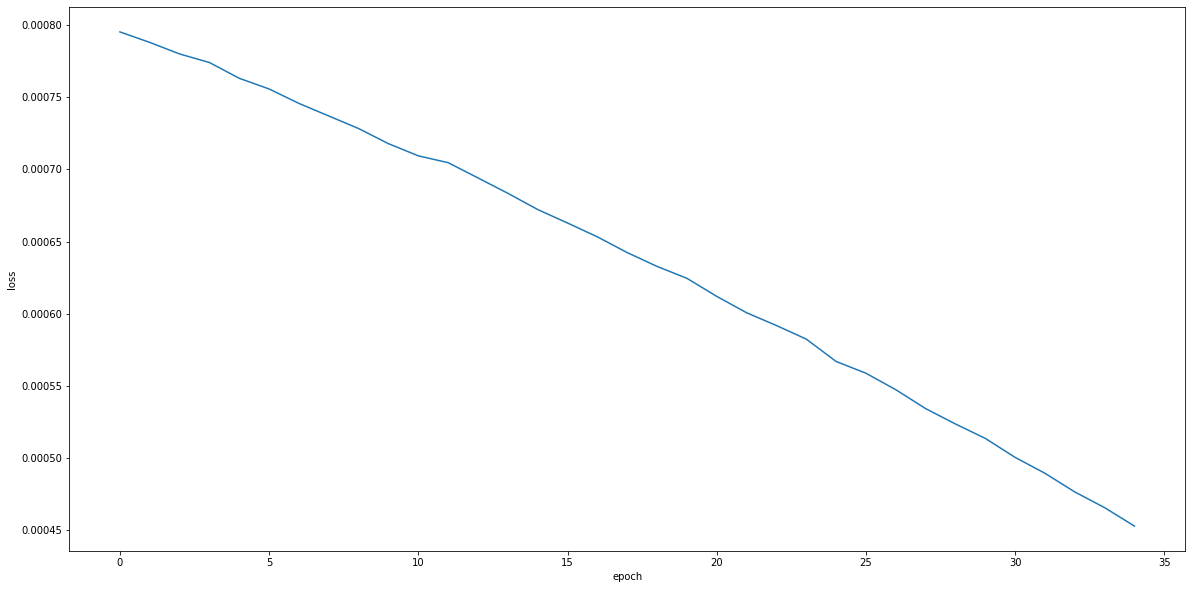

In [12]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

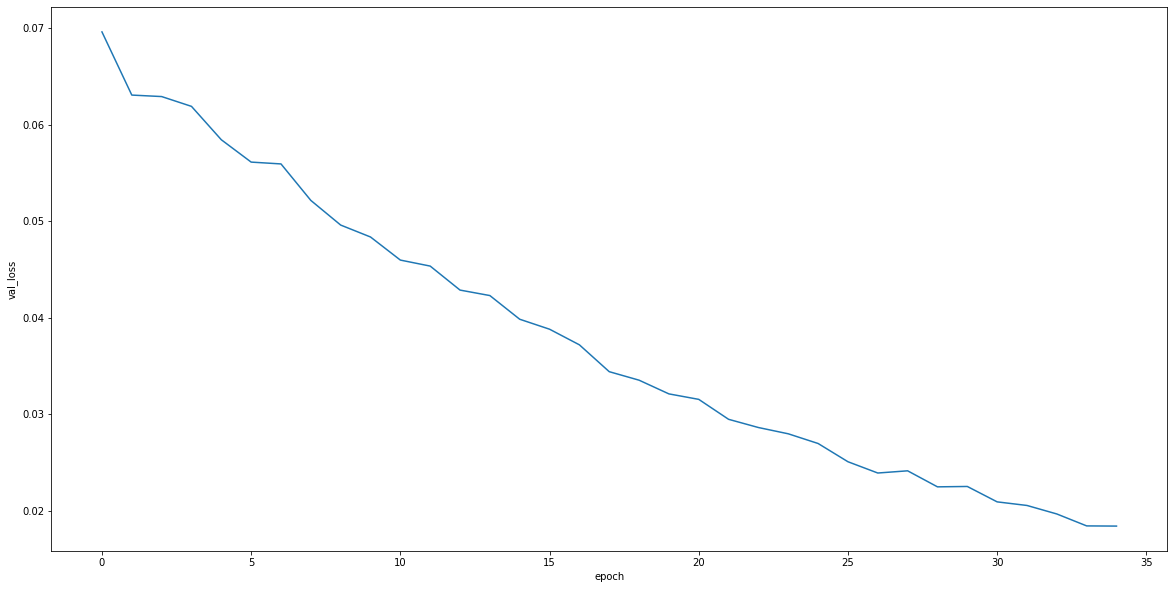

In [13]:
plt.plot(history.history["val_loss"])
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

In [14]:

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example, key="cleaned_ingredients"):
    LABELED_TFREC_FORMAT = {
#         "image_name": tf.io.FixedLenFeature([], tf.string),
#         "image": tf.io.FixedLenFeature([], tf.string),
        "cleaned_ingredients": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
#         "orig_ingredients": tf.io.FixedLenFeature([], tf.string),
#         "title": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "title": tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
#         "instructions": tf.io.FixedLenFeature([], tf.string),
    }
    

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    # not being used in model, just there to be able to work tfrecs
    return example[key]


def load_dataset(filenames, ordered = False, key="cleaned_ingredients"):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda x: read_labeled_tfrecord(x, key), num_parallel_calls = AUTO) 
    return dataset


# This function is to get our validation tensors
def get_validation_ings(filenames, key, ordered = True):
    dataset = load_dataset(filenames, ordered = ordered, key="cleaned_ingredients" if key == "ings" else "title")
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset


val_ingredients = get_validation_ings(val_set, "ings", ordered = True)
val_titles = get_validation_ings(val_set, "titles", ordered = True)

In [15]:
val_images, val_ings, val_titles = [], [], []
# for  i in val_titles:
#     val_titles.append(i.numpy())
for i in val_dataset:
    val_images.append(i.numpy())
for i in val_ingredients:
    val_ings.append(i.numpy())
val_images = np.concatenate(val_images)
val_ings = np.concatenate(val_ings)
# val_titles = np.concatenate(val_titles)
len(val_images), len(val_ings)

2021-12-10 23:38:17.427750: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 155863, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1639179497.427674612","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 155863, Output num: 0","grpc_status":3}


(3364, 3364)

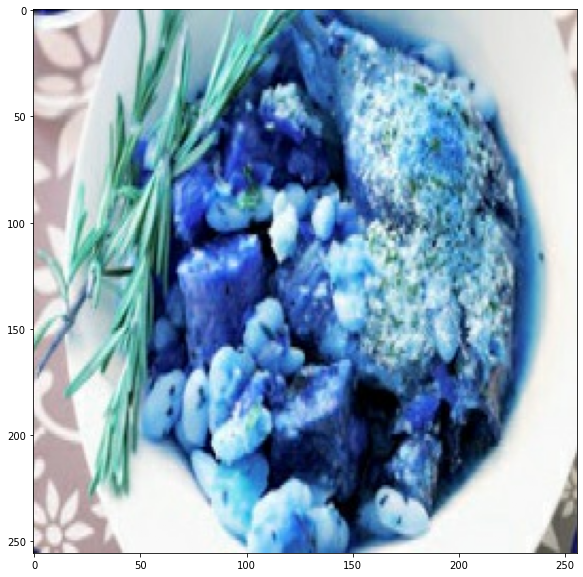

In [16]:
plt.imshow(val_images[0])

In [17]:
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(val_dataset, batch_size=BATCH_SIZE, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

106/106 [==============================] - 9s 17ms/step


In [18]:
feature_vectors.shape

TensorShape([3364, 256])

In [19]:
neighbours = []
num_batches = feature_vectors.shape[0] // BATCH_SIZE

for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = start_idx + BATCH_SIZE
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

  0%|          | 0/105 [00:00<?, ?it/s]

In [20]:
def get_ingredients(ings):
    i = pickle.load(open("../input/deepfoodie/index_to_words.pkl", 'rb'))
    return [i[j] for j in range(len(ings)) if ings[j] == 1]

original model
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
avg_pooling (GlobalAveragePo (None, 2048)              0         
_________________________________________________________________
ing_embedding (Dense)        (None, 256)               524544    
Total params: 24,112,256
Trainable params: 24,059,136
Non-trainable params: 53,120
_________________________________________________________________
None
['room', 'kosher', 'oil', 'flour', 'cream', 'cut', 'stick', 'sugar', 'tablespoon', 'vanilla', 'surface']
['butter', 'kosher', 'oil', 'flour', 'cut', 'rice', 'quinoa', 'buttermilk', 'pan', 'soda', 'wheat', 'sunflower', 'm

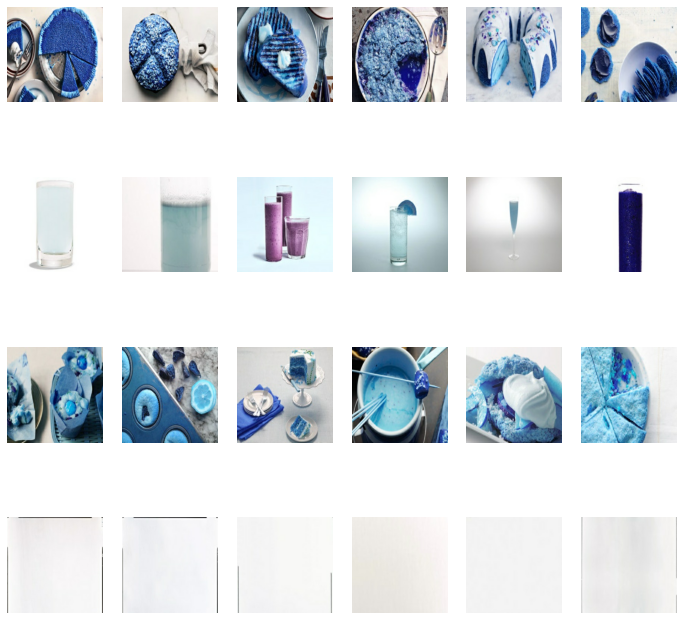

In [21]:
nrows = 4
ncols = k_neighbours + 1
model, _ = get_encoder()
plt.figure(figsize=(12, 12))
position = 1
# ings = get_encoder()[0].predict(val_dataset, batch_size=BATCH_SIZE)
for _ in range(nrows):
    anchor_idx = np.random.choice(range(len(val_images)))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(val_images[indices[j]])
        print(str(get_ingredients(val_ings[indices[j]])))
#         plt.title(str(get_ingredients(val_ings[indices[j]])))
        plt.axis("off")
        position += 1